# What makes a good book?

## 📚 Background

![books](books_pattern.jpg)

As reading trends keep changing, an ambitious online bookstore has seen a boost in popularity following an intense marketing campaign. Excited to keep the momentum going, the bookstore has kicked off a challenge among their data scientists. 

They've equipped the team with a comprehensive dataset featuring book prices, reviews, author details, and categories. 

The team is all set to tackle this challenge, aiming to build a model that accurately predicts book popularity, which will help the bookstore manage their stock better and tweak their marketing plans to suit what their readers love the most.

So, we are here to help them make predictions.

## 📊 The Data

The data provided with a single dataset to use. A summary and preview is provided below.

## books.csv

| Column     | Description              |
|------------|--------------------------|
| `'title'` | Book title. |
| `'price'` | Book price. |
| `'review/helpfulness'` | The number of helpful reviews over the total number of reviews. | 
| `'review/summary'` | The summary of the review. |
| `'review/text'`| The review's full text. |
| `'description'` | The book's description. |
| `'authors'` | Author. | 
| `'categories'` | Book categories. |
| `'popularity'` | Whether the book was popular or unpopular. | 


# Solution Approach Explanation
In this case, to predict the necessary books to let the online bookstore keep their momentum going, there will be used a NLP algorithm which uses Sentiment modeling, Random Forest and Logistics regression.

## 1. Importing Necessary Libraries

In [22]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

books = pd.read_csv("data/books.csv")

books.head(5)

,title,price,review/helpfulness,review/summary,review/text,description,authors,categories,popularity
0,We Band of Angels: The Untold Story of America...,10.88,2/3,A Great Book about women in WWII,I have alway been a fan of fiction books set i...,"In the fall of 1941, the Philippines was a gar...",'Elizabeth Norman','History',Unpopular
1,Prayer That Brings Revival: Interceding for Go...,9.35,0/0,Very helpful book for church prayer groups and...,Very helpful book to give you a better prayer ...,"In Prayer That Brings Revival, best-selling au...",'Yong-gi Cho','Religion',Unpopular
2,The Mystical Journey from Jesus to Christ,24.95,17/19,Universal Spiritual Awakening Guide With Some ...,The message of this book is to find yourself a...,THE MYSTICAL JOURNEY FROM JESUS TO CHRIST Disc...,'Muata Ashby',"'Body, Mind & Spirit'",Unpopular
3,Death Row,7.99,0/1,Ben Kincaid tries to stop an execution.,The hero of William Bernhardt's Ben Kincaid no...,"Upon receiving his execution date, one of the ...",'Lynden Harris','Social Science',Unpopular
4,Sound and Form in Modern Poetry: Second Editio...,32.50,18/20,good introduction to modern prosody,There's a lot in this book which the reader wi...,An updated and expanded version of a classic a...,"'Harvey Seymour Gross', 'Robert McDowell'",'Poetry',Unpopular


In [23]:
books["popularity"].nunique()

2

## 2. Downloading Necessary Packages

In [24]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/repl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/repl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/repl/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## 3. Text Data Preprocessing
Normalizing the text data into a standart by case folding: removing punctuations, numbers by using regex.

In [25]:
from nltk.corpus import stopwords

books["review/summary"] = books["review/summary"] = books["review/summary"].str.lower()
books["review/summary"] = books["review/summary"].str.replace("[^\w\s]", "")
books["review/summary"] = books["review/summary"].str.replace("[\d]", "")

sw = stopwords.words("english")

books["review/summary"] = books["review/summary"].apply(lambda x : " ".join(x for x in str(x).split() if x not in sw))

### 3.1 Deleting Rarewords

In [26]:
temp_df = pd.Series(" ".join(books["review/summary"]).split()).value_counts()

drops = temp_df[temp_df <= 10] #threshold can differ

books["review/summary"]  = books["review/summary"].apply(lambda x : " ".join(x for x in str(x).split() if x not in drops))

### 3.2 Tokenization

In [27]:
books["review/summary"].apply(lambda x: TextBlob(x).words).head()

0      [great, book, women, wwii]
1         [helpful, book, church]
2              [spiritual, guide]
3                          [stop]
4    [good, introduction, modern]
Name: review/summary, dtype: object

### 3.3 Lemmatization

In [28]:
books["review/summary"] = books["review/summary"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

## 4. Text Visualization
Providing a bar chart to show the most used words in the reviews summary section.

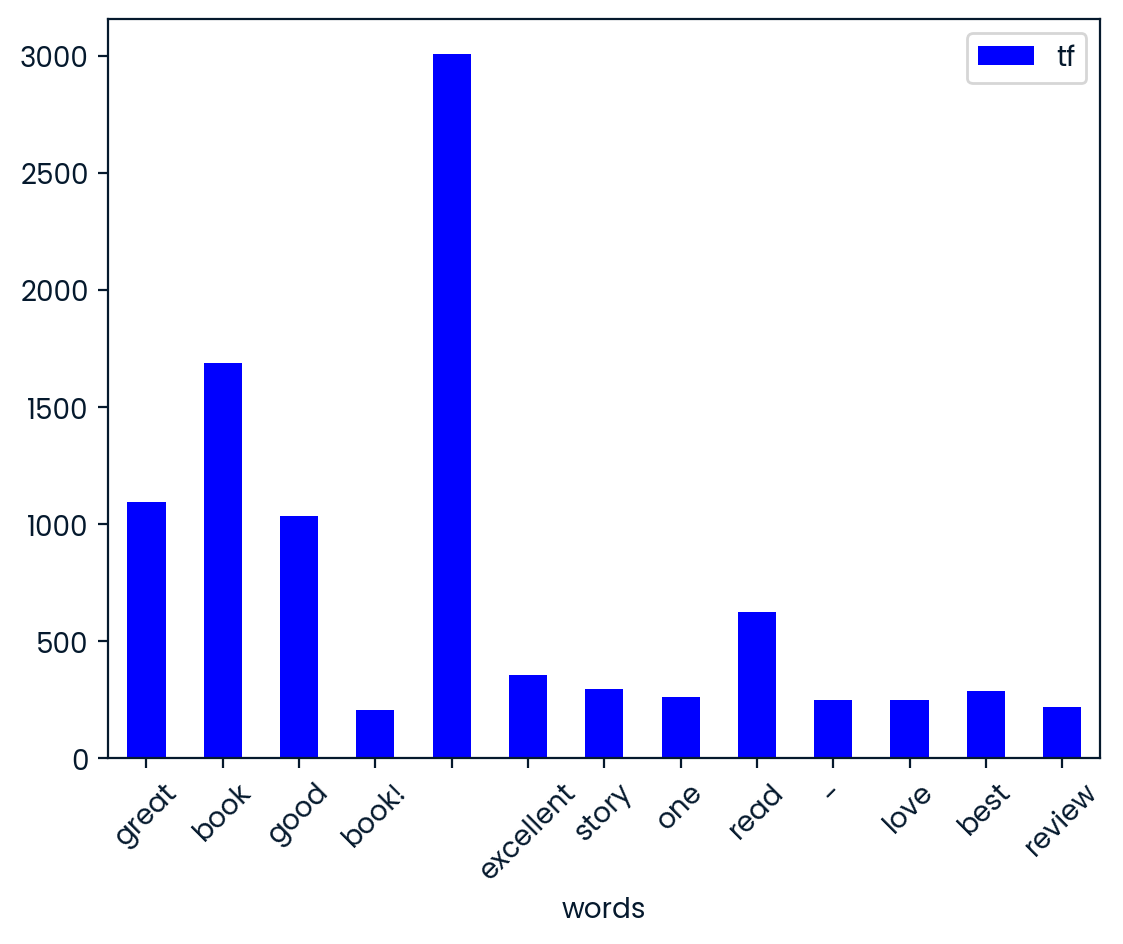

In [29]:
tf = books["review/summary"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.columns = ["words", "tf"]

tf.sort_values("tf", ascending=False)

tf[tf["tf"] > 200].plot.bar(x="words", y="tf", color="b")
plt.xticks(rotation=45) 
plt.show()

## 5. Sentiment Analysis

In [30]:
sia = SentimentIntensityAnalyzer()

books["review/summary"][0: 10].apply(lambda x: sia.polarity_scores(x)["compound"])

books["polarity_score"] = books["review/summary"].apply(lambda x: sia.polarity_scores(x)["compound"])

### 5.1 Label Encoding Popularity
Label Encoding "Popularity" column to have a better understanding and usage of dataset.

In [31]:
books['popularity'].nunique() # has 2 different unique values

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
books['popularity'] = le.fit_transform(books['popularity'])

print(books["popularity"])

0        1
1        1
2        1
3        1
4        1
        ..
15714    1
15715    0
15716    0
15717    0
15718    0
Name: popularity, Length: 15719, dtype: int64


### 5.2 Finding Helpfulness / All Reviews Ratio
This function is made for finding Finding Helpfulness / All Reviews Ratio by changing "review/helpfulness" column from object to float type. This was also made to have a better understanding and usage of dataset.

In [32]:
books['review/helpfulness'].astype(str)

def convert_fraction_to_float(value):
    if value == '0/0' or pd.isna(value):
        return np.nan
    try:
        numerator, denominator = map(float, value.split('/'))
        if denominator == 0:
            return np.nan
        return numerator / denominator
    except Exception as e:
        print(f"Error converting value {value}: {e}")
        return np.nan

books['review/helpfulness'] = books['review/helpfulness'].apply(convert_fraction_to_float)

print(books['review/helpfulness'])

0        0.666667
1             NaN
2        0.894737
3        0.000000
4        0.900000
           ...   
15714         NaN
15715    1.000000
15716    0.750000
15717    1.000000
15718         NaN
Name: review/helpfulness, Length: 15719, dtype: float64


## 6. Feature Engineering

In [33]:
books["sentiment_label"] = books["review/summary"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg") ## for loopla dene

books["sentiment_label"].value_counts()

print(books.groupby("sentiment_label")["price"].mean())

books["sentiment_label"] = LabelEncoder().fit_transform(books["sentiment_label"])

y = books["sentiment_label"]

sentiment_label
neg    16.117721
pos    15.485445
Name: price, dtype: float64


## 7. Count and TF-IDF Vectorizing
In both word and ngram frequencies.

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

X = books["review/summary"]

### 7.1 Word Frequency

In [35]:
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)

vectorizer.get_feature_names_out()
X_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [36]:
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

### 7.2 N-GRAM Frequency

In [37]:
vectorizer_2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))

X_n = vectorizer_2.fit_transform(X)

vectorizer_2.get_feature_names_out()
X_n.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)

## 8. Logistics Regression

In [39]:
log_model = LogisticRegression().fit(X_tf_idf_word, y)

print("Accracy : ",
      cross_val_score(log_model,
                X_tf_idf_word,
                y,
                scoring="accuracy",
                cv=5).mean())

Accracy :  0.9773523335106326


## 9. Random Forest Regression

In [40]:
from sklearn.ensemble import RandomForestClassifier

# Count Vectors
rf_model = RandomForestClassifier().fit(X_count, y)

print(cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean())

0.9930021599758418


### 9.1 Cross Validation : TF-IDF

In [41]:
# Word-Level
rf_model = RandomForestClassifier().fit(X_tf_idf_word, y)
print(cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean())

# N-GRAM
rf_model = RandomForestClassifier().fit(X_tf_idf_ngram, y)
print(cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean())

0.992874913273084
0.9928112595622244


## 10. Hyperparameter Optimization

In [42]:
empty_rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [8, None],
             "max_features": [7, "auto"],
             "min_samples_split": [2, 5, 8],
             "n_estimators": [100, 200]}

rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=True).fit(X_count, y)

rf_best_grid.best_params_

rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count, y)

cross_val_score(rf_final, X_count, y, cv=5, n_jobs=-1).mean()

Fitting 5 folds for each of 24 candidates, totalling 120 fits


0.9918569598906736

## 11. Logistics Regression Model Validation

In [43]:
new_review = pd.Series("this product is great")

new_review = TfidfVectorizer().fit(X).transform(new_review)

log_model.predict(new_review)

array([1])

## 12. Visualizations
Providing visuals regarding the NLP model that is used by taking advantage of the visualization tool of nltk library WordCloud and analytical plots of given dataset.
### 12.1 WordCloud

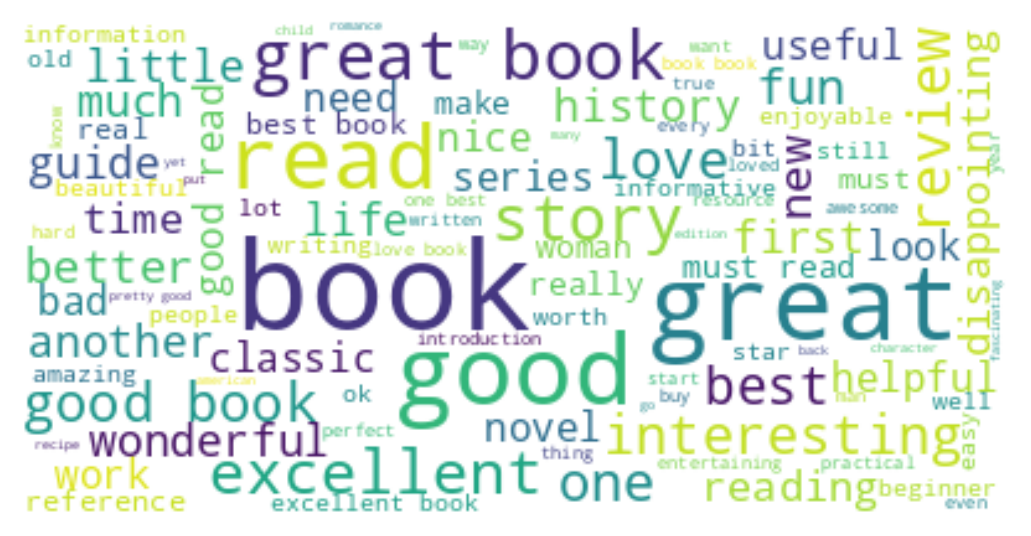

In [44]:
text = " ".join(i for i in books["review/summary"])

wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

This word cloud shows that there are a lot of good reviews in review/summary even though negative reviews are greater in numbers.
### 12.2 Helpfulness / Review Frequency

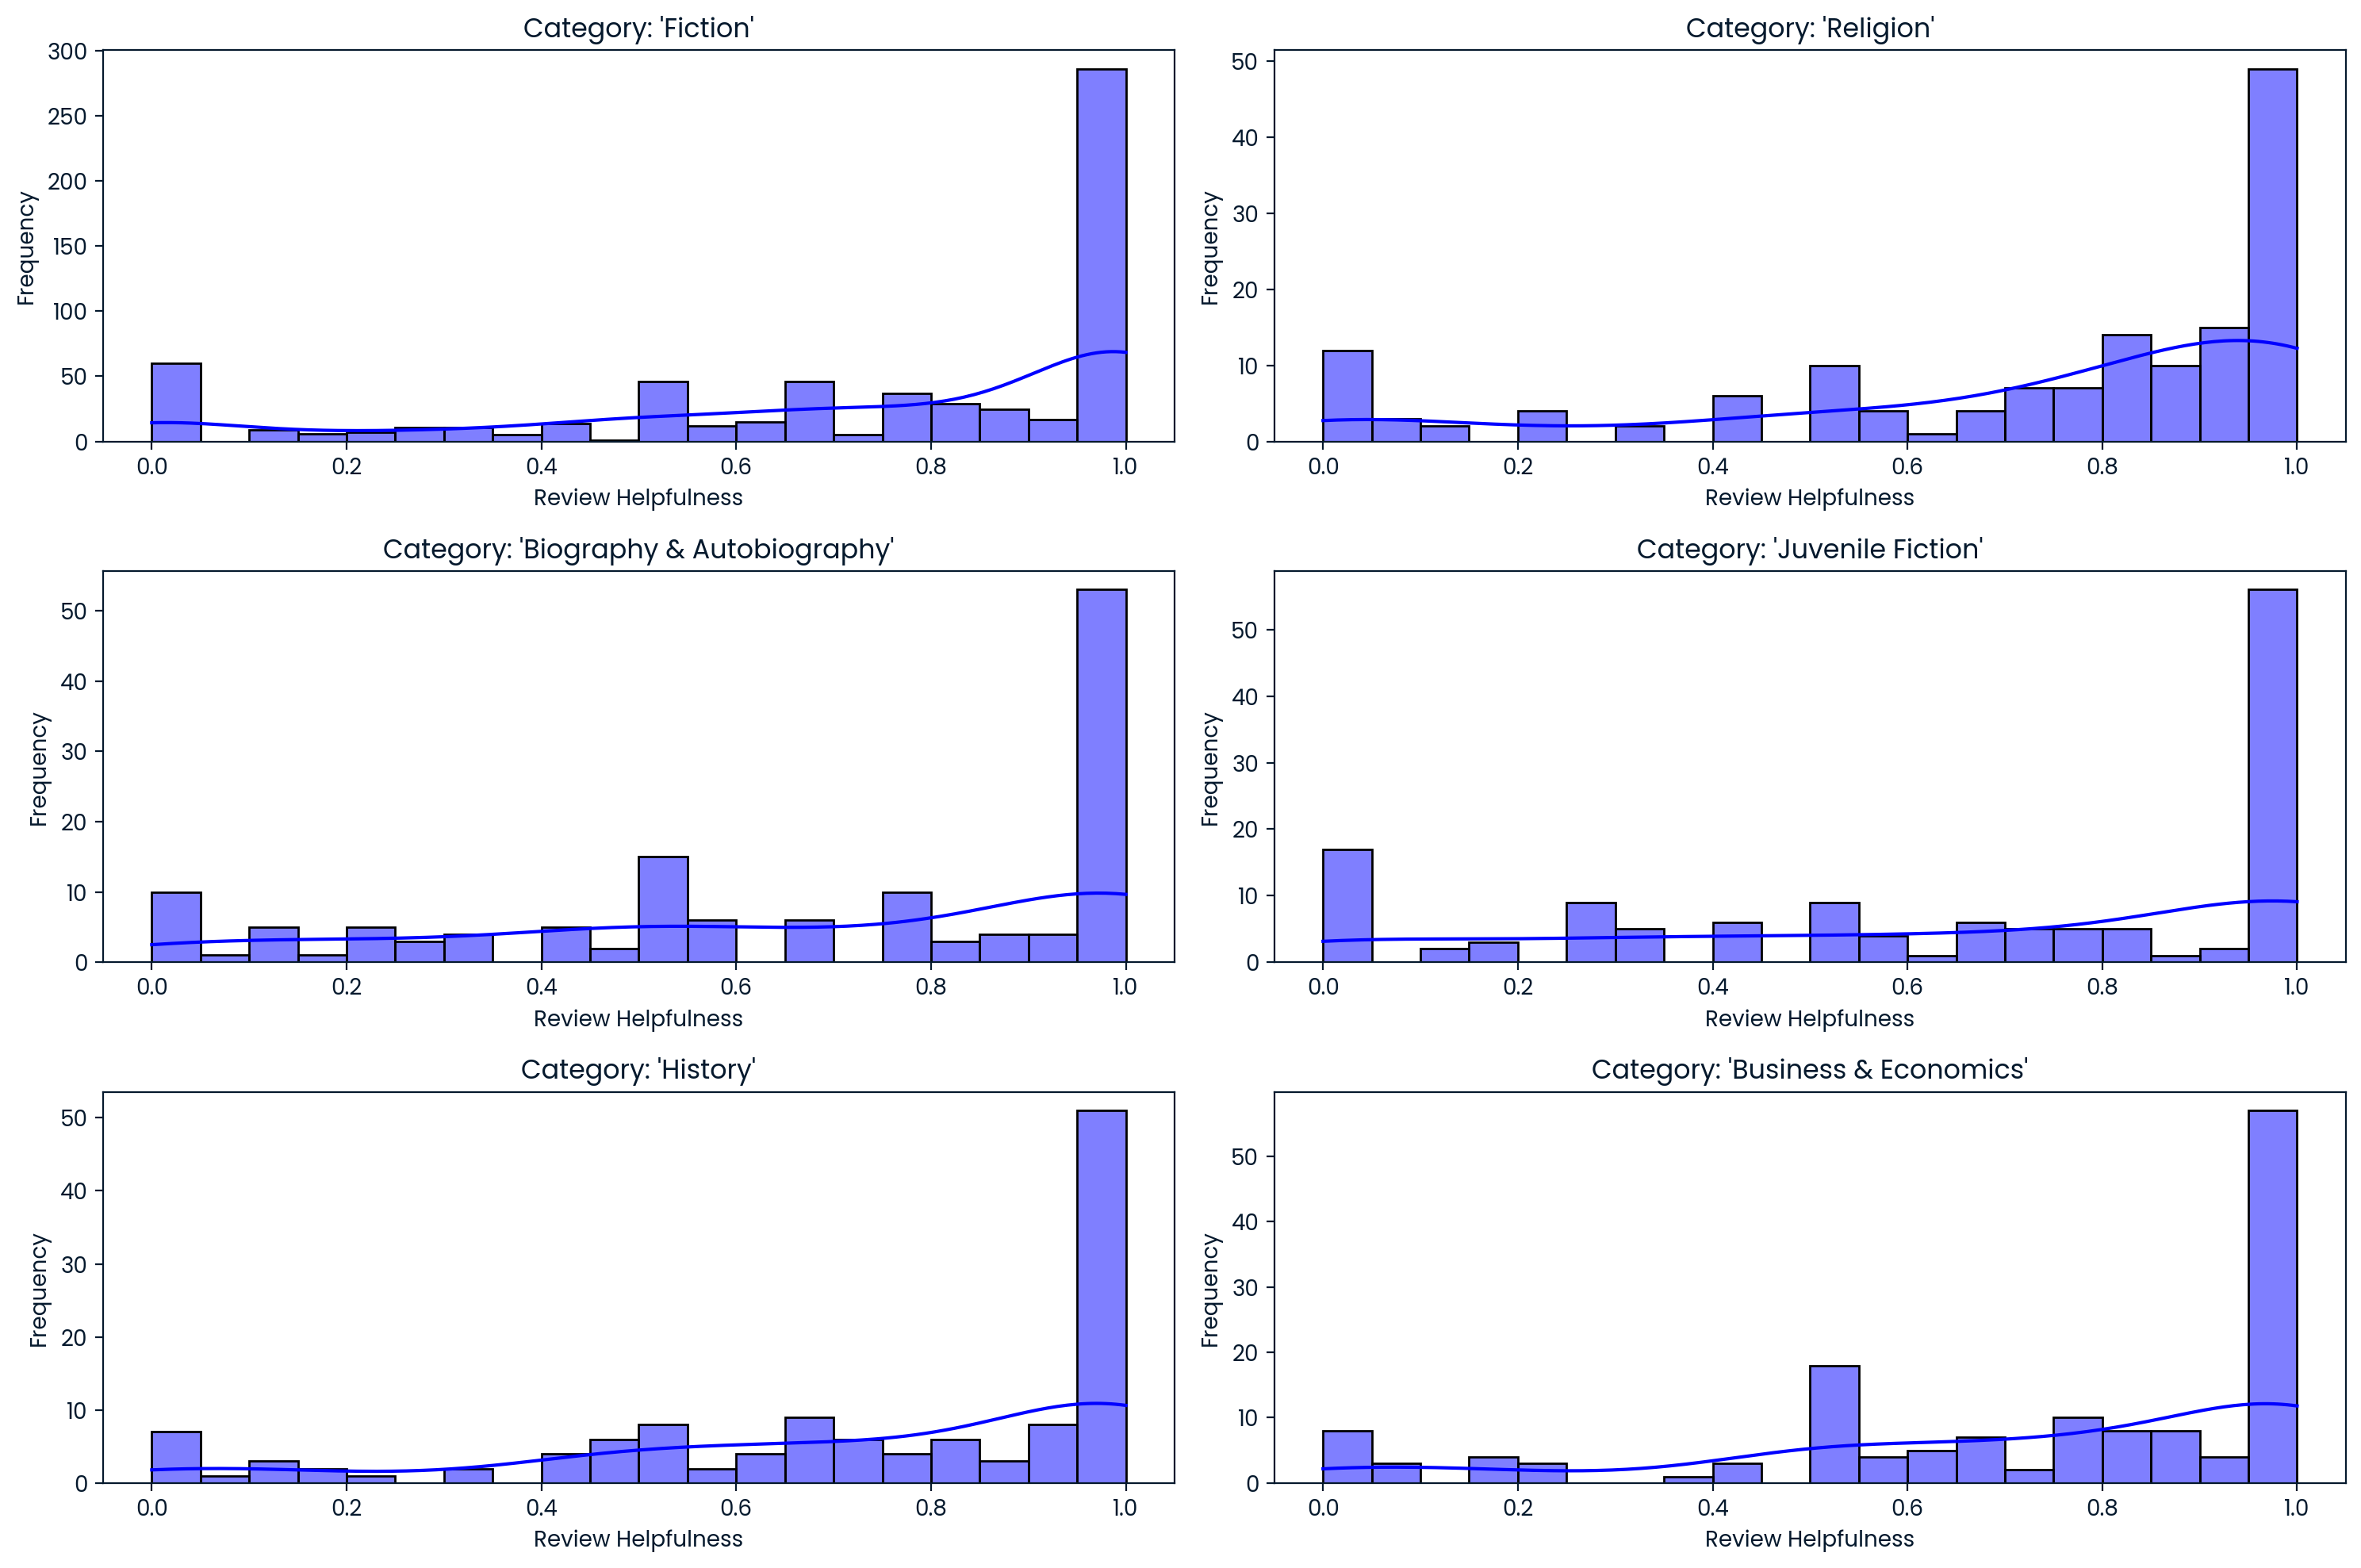

In [47]:
import seaborn as sns

top_6_categories = books['categories'].value_counts().nlargest(6).index

filtered_books_top_5 = books[(books["popularity"] == 1) & (books["sentiment_label"] > 0) & (books['categories'].isin(top_6_categories))]

fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()
for i, category in enumerate(top_6_categories):
    category_books = filtered_books_top_5[filtered_books_top_5['categories'] == category]
    sns.histplot(data=category_books, x="review/helpfulness", bins=20, kde=True, ax=axes[i], color='blue')
    axes[i].set_title(f"Category: {category}")
    axes[i].set_xlabel("Review Helpfulness")
    axes[i].set_ylabel("Frequency")

for j in range(len(top_6_categories), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 12.3 Sentiment Label - Popularity
By looking at the following bar charts, we can say that this online bookstore shall put some more efforts on Fiction, Juvenile Fiction and Business & Economics categories much more than others.

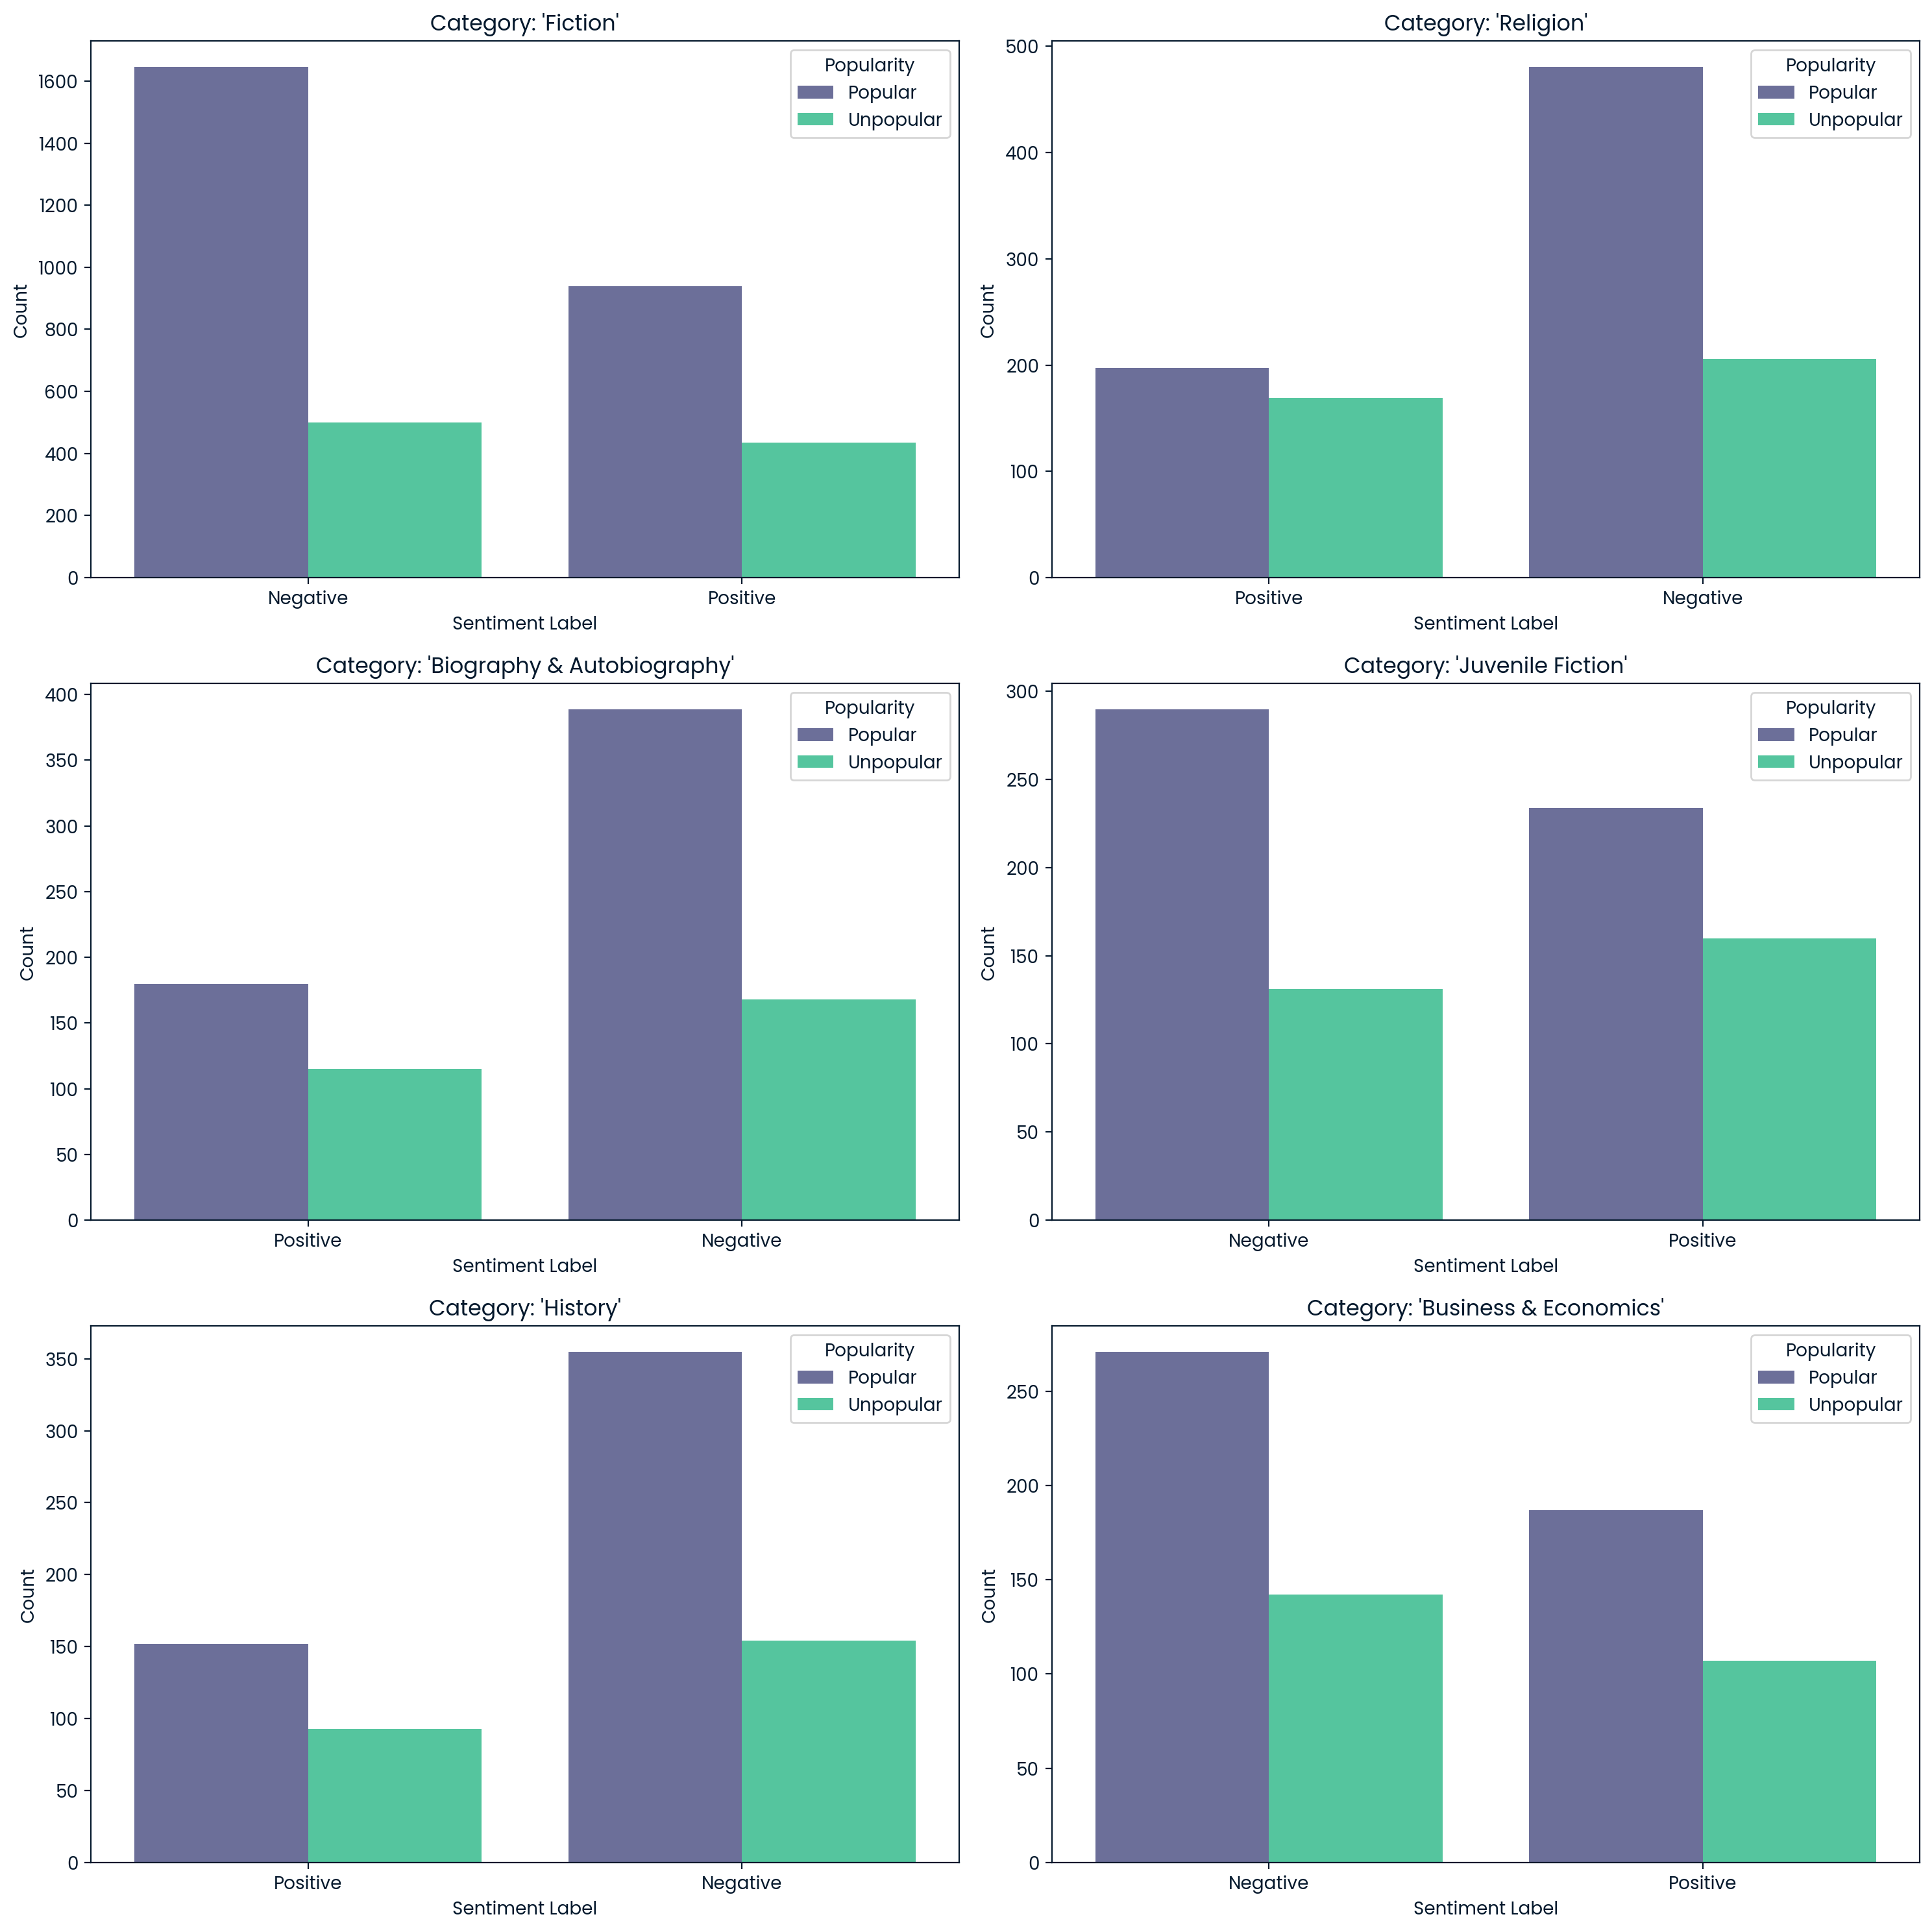

In [48]:
filtered_books_top_6 = books[books['categories'].isin(top_6_categories)]

filtered_books_top_6['sentiment_label'] = filtered_books_top_6['sentiment_label'].replace({0: 'Negative', 1: 'Positive'})
filtered_books_top_6['popularity'] = filtered_books_top_6['popularity'].replace({0: 'Unpopular', 1: 'Popular'})

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, category in enumerate(top_6_categories):
    category_books = filtered_books_top_6[filtered_books_top_6['categories'] == category]
    sns.countplot(data=category_books, x="sentiment_label", hue="popularity", ax=axes[i])
    axes[i].set_title(f"Category: {category}")
    axes[i].set_xlabel("Sentiment Label")
    axes[i].set_ylabel("Count")
    axes[i].legend(title="Popularity", loc='upper right')

for j in range(len(top_6_categories), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 12.4 Price - Popularity

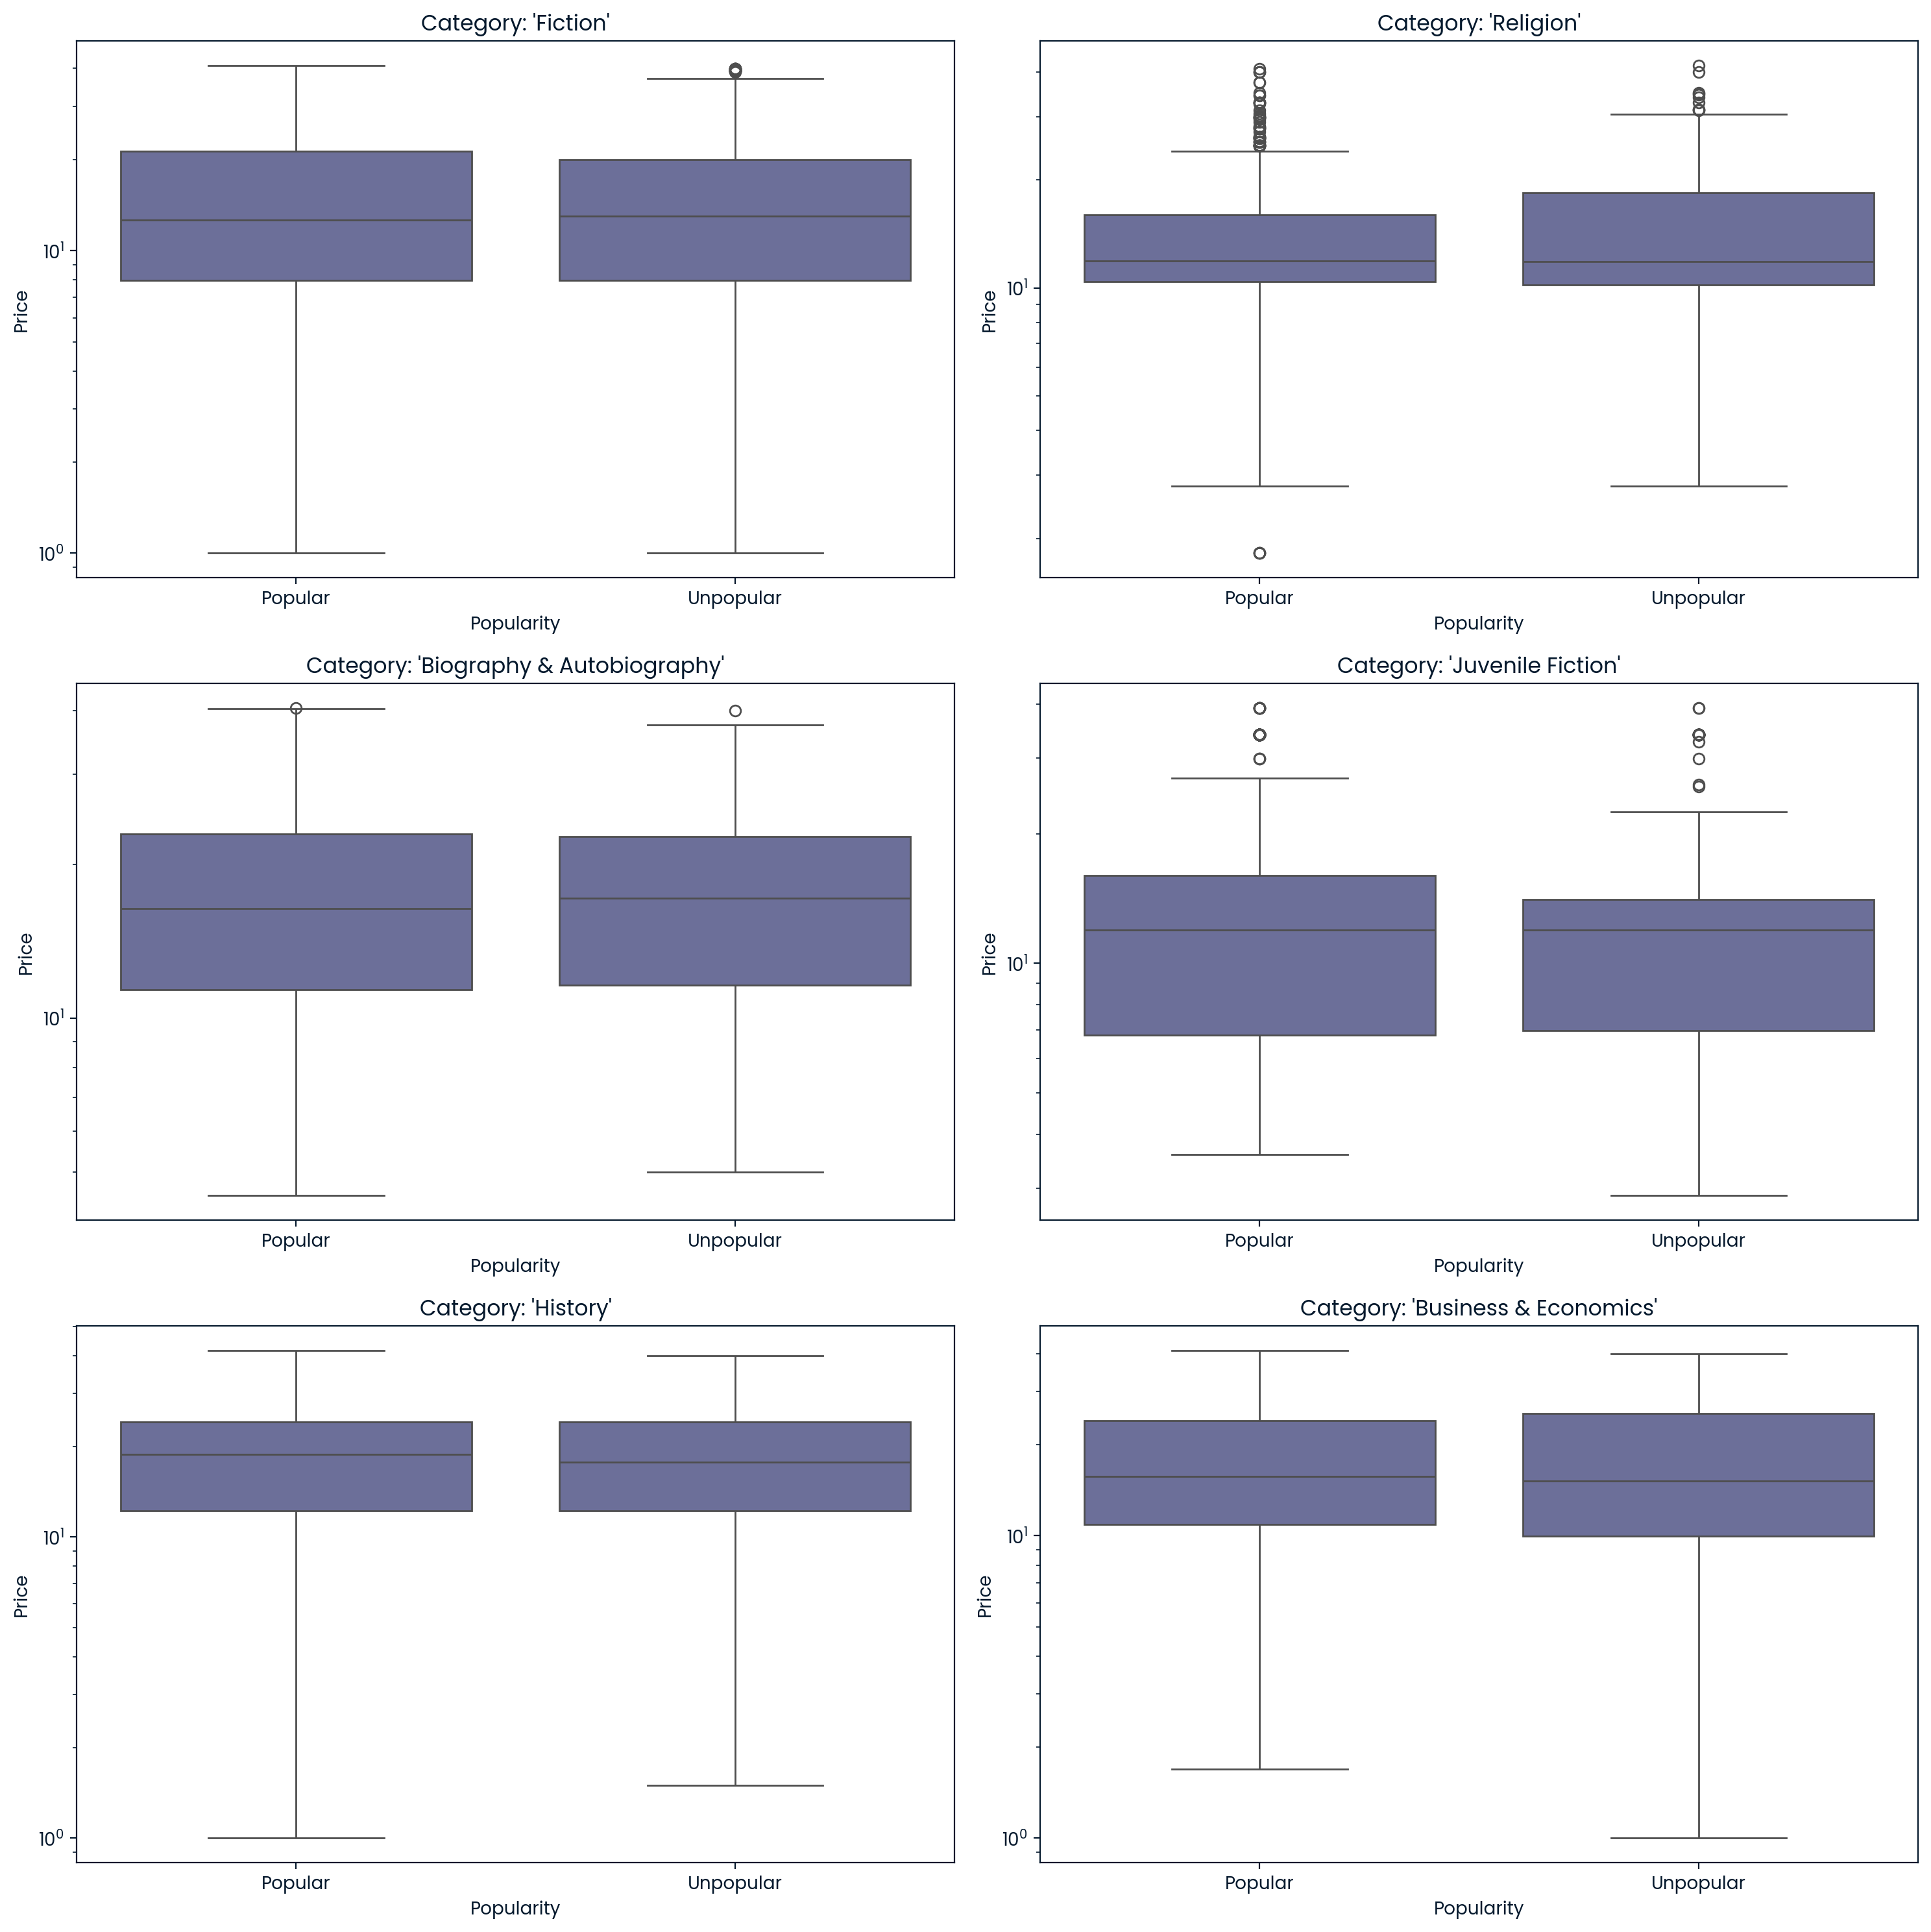

In [50]:
filtered_books_top_6 = books[books['categories'].isin(top_6_categories)]

filtered_books_top_6['popularity'] = filtered_books_top_6['popularity'].replace({0: 'Unpopular', 1: 'Popular'})

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, category in enumerate(top_6_categories):
    category_books = filtered_books_top_6[filtered_books_top_6['categories'] == category]
    sns.boxplot(data=category_books, x="popularity", y="price", ax=axes[i])
    axes[i].set_title(f"Category: {category}")
    axes[i].set_xlabel("Popularity")
    axes[i].set_ylabel("Price")
    axes[i].set_yscale('log')

for j in range(len(top_6_categories), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 13. Conclusion / Business Insights
When we compare the top 6 popular categories in terms of sentiment label, popularity, and review helpfulness frequency distribution plots, it becomes clear that the bookstore should put more effort into the Fiction, Juvenile Fiction, and Business & Economics categories. These three categories showed a more consistent increase in terms of review helpfulness, as stated above.

Additionally, by examining the relationship between the popularity and prices of these top 6 categories, we observe that despite the higher prices in the categories with the most consistent increase, the popularity also increases with positive sentiment labels. This indicates that customer satisfaction and loyalty, reflected through sentiment labels, have a strong correlation with sales.

Thus, we can conclude that maintaining a high and steady customer lifetime value (CLV) is crucial. My suggestion to the bookstore is to prioritize the Fiction, Juvenile Fiction, and Business & Economics categories, and then expand focus to all top 6 categories. Paying more attention to these categories will likely enhance customer satisfaction and drive sales growth.